In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zm_stars1 = pd.read_csv('/content/drive/MyDrive/Data/star_galaxy/ZMs/last/star_45_0.csv')
zm_galaxies1 = pd.read_csv('/content/drive/MyDrive/Data/star_galaxy/ZMs/last/galaxy_45_0.csv')
zm_stars1.drop("Unnamed: 0", axis = 1, inplace = True)
zm_galaxies1.drop("Unnamed: 0", axis = 1, inplace = True)
zms1 = np.array(zm_stars1)
zmg1 = np.array(zm_galaxies1)

all_zm_data = np.concatenate([zmg1,zms1])
len(zmg1), len(zms1), len(all_zm_data)

(780, 545, 1325)

In [ ]:
galaxies_labels = np.zeros(780)
stars_labels = np.ones(545)
all_labels = np.concatenate([galaxies_labels, stars_labels])
len(all_labels)

1325

In [ ]:
total_samples = len(all_zm_data)

class_weights = {
    0: total_samples / (3*len(zmg1)),  # Class 0 (or Class 1) weight
    1: total_samples / (3*len(zms1)),   # Class 1 (or Class 2) weight
}

print("Class Weights based on Inverse Class Frequency:")
print("Class 1 Weight:", class_weights[0])
print("Class 2 Weight:", class_weights[1])

Class Weights based on Inverse Class Frequency:
Class 1 Weight: 0.5662393162393162
Class 2 Weight: 0.8103975535168195


In [ ]:
X_train_list=[]
y_train_list=[]
X_test_list=[]
y_test_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]
TP_list = []
FP_list = []
TN_list = []
FN_list = []
test_indx = []

for i in range (10):
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    test_indx.append(test_indices)

    class_weights = {0: len(all_zm_data) / (2*len(zmg1)), 1: len(all_zm_data) / (2*len(zms1))}

    model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
    gz2_training_model = model.fit(X_train, y_train)
    models.append(gz2_training_model)

    y_pred = model.predict(X_test)
    Y_pred.append(y_pred)

    con0 = metrics.confusion_matrix(y_test, y_pred)
    cons.append(con0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    TN_list.append(tn)
    FP_list.append(fp)
    FN_list.append(fn)
    TP_list.append(tp)

    acc = metrics.accuracy_score(y_test, y_pred)
    accs.append(acc)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    fprs.append(fpr)
    tprs.append(tpr)

    auc = metrics.roc_auc_score(y_test, y_pred)
    aucs.append(auc)

In [ ]:
output_el_path = '/content/drive/MyDrive/Data/win_classifier_material'
import os
pickle_el_filename = 'test_indx_svm_zms_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(test_indx, pickle_file)


0.8400000000000001 1.0


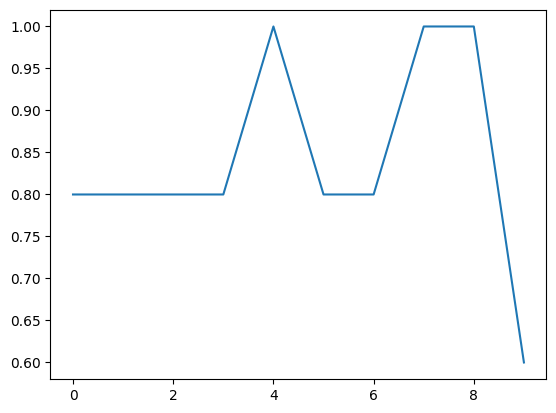

In [ ]:
print(np.mean(accs), np.max(aucs))
plt.plot(accs)

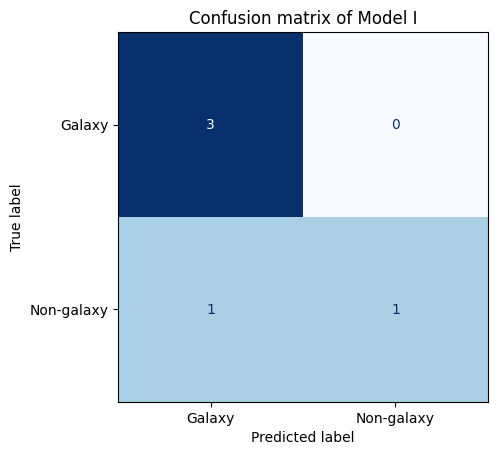

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_names=["Galaxy", "Non-galaxy"]

disp = ConfusionMatrixDisplay.from_estimator(models[6],X_test_list[6],y_test_list[6],display_labels=target_names,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix of Model I")
disp.im_.colorbar.remove()
# plt.savefig("/content/drive/MyDrive/Data/star_galaxy/figs/cm_svm_galaxy_nongalaxy.eps", format="eps")
plt.show()

In [ ]:
output_el_path = '/content/drive/MyDrive/Data/star_galaxy'
import os
pickle_el_filename = 'aucs_svm_zms_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(aucs, pickle_file)


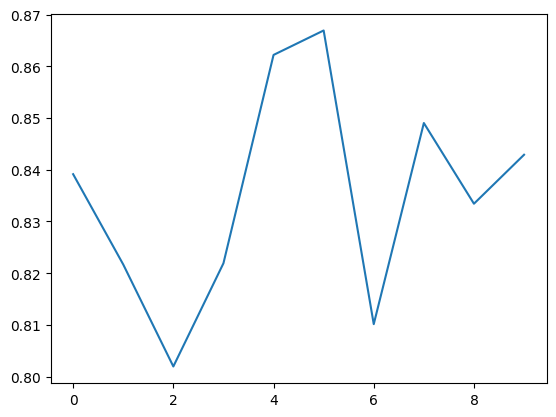

In [ ]:
plt.plot(aucs)

In [ ]:
def metric(tp, fp, fn, tn):
   acu = (tp + tn) / (tp + tn + fn + fp)
   pre_p = tp / (tp + fp)
   pre_n = tn / (tn + fn)
   recal_p = tp / (tp + fn)
   recal_n = tn / (tn + fp)
   f1_p = (2 * (pre_p) * (recal_p)) / ((pre_p) + (recal_p))
   f1_n = (2 * (pre_n) * (recal_n)) / ((pre_n) + (recal_n))
   hss1 = (tp - fp) / (tp + fn)
   hss2 = (2 * ((tp * tn) - (fn * fp))) / (((tp + fn) * (tn + fn)) + ((tp + fp) * (tn + fp)))
   ch = ((tp + fp) * (tp + fn)) / (tp + fn + tn + fp)
   gs = (tp - ch) / (tp + fp + fn - ch)
   tss = (tp / (tp + fn)) - (fp / (fp + tn))
   return acu, pre_p, pre_n, recal_p, recal_n, hss1, tss, f1_p, f1_n, hss2, gs

In [ ]:
acus=[]
pre_ps=[]
pre_ns=[]
recal_ps=[]
recal_ns=[]
hss1s=[]
tsss=[]
f1_ps=[]
f1_ns=[]
hss2s=[]
gss=[]

# Calculate metrics for each set of TP, FP, FN, TN values
performance_metrics = []
for i in range(10):
    acu, pre_p, pre_n, recal_p, recal_n, hss1, tss, f1_p, f1_n, hss2, gs = metric(TP_list[i], FP_list[i], FN_list[i], TN_list[i])
    acus.append(acu)
    pre_ps.append(pre_p)
    pre_ns.append(pre_n)
    recal_ps.append(recal_p)
    recal_ns.append(recal_n)
    hss1s.append(hss1)
    tsss.append(tss)
    f1_ps.append(f1_p)
    f1_ns.append(f1_n)
    hss2s.append(hss2)
    gss.append(gs)

acus_mean = np.mean(acus)
acus_std = np.std(acus)

pre_ps_mean = np.mean(pre_ps)
pre_ps_std = np.std(pre_ps)

pre_ns_mean = np.mean(pre_ns)
pre_ns_std = np.std(pre_ns)

recal_ps_mean = np.mean(recal_ps)
recal_ps_std = np.std(recal_ps)

recal_ns_mean = np.mean(recal_ns)
recal_ns_std = np.std(recal_ns)

hss1s_mean = np.mean(hss1s)
hss1s_std = np.std(hss1s)

tsss_mean = np.mean(tsss)
tsss_std = np.std(tsss)

f1_ps_mean = np.mean(f1_ps)
f1_ps_std = np.std(f1_ps)

f1_ns_mean = np.mean(f1_ns)
f1_ns_std = np.std(f1_ns)

hss2s_mean = np.mean(hss2s)
hss2s_std = np.std(hss2s)

gss_mean = np.mean(gss)
gss_std = np.std(gss)

auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

In [ ]:
print("Mean and Standard Deviation Values:")
print("Accuracy - Mean:", acus_mean, "  Std:", acus_std)
print("Precision Positive - Mean:", pre_ps_mean, "  Std:", pre_ps_std)
print("Precision Negative - Mean:", pre_ns_mean, "  Std:", pre_ns_std)
print("F1 Positive - Mean:", f1_ps_mean, "  Std:", f1_ps_std)
print("F1 Negative - Mean:", f1_ns_mean, "  Std:", f1_ns_std)
print("Recall Positive - Mean:", recal_ps_mean, "  Std:", recal_ps_std)
print("Recall Negative - Mean:", recal_ns_mean, "  Std:", recal_ns_std)
print("HSS1 - Mean:", hss1s_mean, "  Std:", hss1s_std)
print("HSS2 - Mean:", hss2s_mean, "  Std:", hss2s_std)
print("GS - Mean:", gss_mean, "  Std:", gss_std)
print("TSS - Mean:", tsss_mean, "  Std:", tsss_std)
print("AUC - Mean:", auc_mean, "  Std:", auc_std)

Mean and Standard Deviation Values:
Accuracy - Mean: 0.836144578313253   Std: 0.018819878737124467
Precision Positive - Mean: 0.7850740315343329   Std: 0.02747680191613402
Precision Negative - Mean: 0.8752438562836747   Std: 0.026904670919737167
F1 Positive - Mean: 0.8049494083820011   Std: 0.022882094686683577
F1 Negative - Mean: 0.8584704687684492   Std: 0.017316220832546043
Recall Positive - Mean: 0.8269638150124413   Std: 0.03476314156787149
Recall Negative - Mean: 0.8429117517381354   Std: 0.020609141573077184
HSS1 - Mean: 0.599511508133043   Std: 0.04592445698114056
HSS2 - Mean: 0.6637245904244955   Std: 0.03865240532040536
GS - Mean: 0.4979572145393255   Std: 0.04356980801881053
TSS - Mean: 0.6698755667505767   Std: 0.04047486360288496
AUC - Mean: 0.8349377833752882   Std: 0.020237431801442482


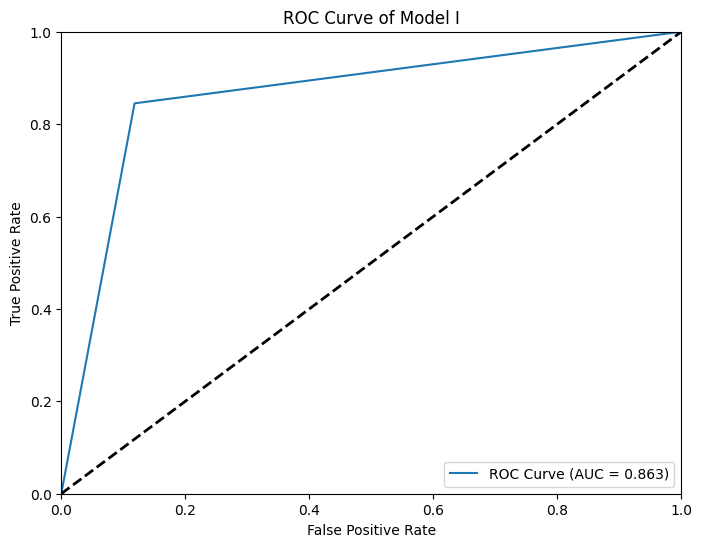

In [ ]:
class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fprs[6], tprs[6], lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(aucs[6]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Model I')
# plt.text(0.1, 0.86, 'AUC = %86.7', fontsize=12, color='blue', ha='center', va='center')
plt.legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/Data/star_galaxy/figs/roc_svm_zms_1.eps", format="eps")

plt.show()


In [ ]:
Pkl_Filename = "/content/drive/MyDrive/Data/star_galaxy/best_models/best_svm_galaxy_star_acc89_tss64.sav"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(models[3], file)

In [ ]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf

--2024-04-13 08:25:57--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2024-04-13 08:25:58--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  

## ROC curves

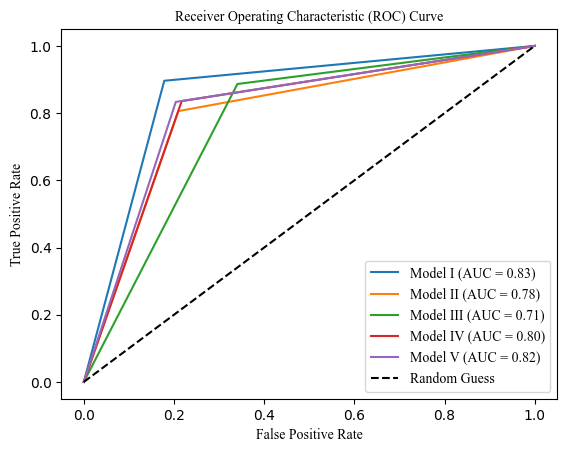

In [ ]:
from matplotlib import font_manager
font_path = '/content/drive/MyDrive/Data/star_galaxy/TIMES.TTF'

classifier_names = ['Model I', 'Model II', 'Model III', 'Model IV', 'Model V']
aucs = [0.83, 0.78, 0.71, 0.80, 0.82]

for i, classifier_name in enumerate(classifier_names):
    with open(f'/content/drive/MyDrive/Data/star_galaxy/fprs_{classifier_name}_galaxy_nonegalaxy.pickle', 'rb') as f:
        fprs = pickle.load(f)
    with open(f'/content/drive/MyDrive/Data/star_galaxy/tprs_{classifier_name}_galaxy_nonegalaxy.pickle', 'rb') as f:
        tprs = pickle.load(f)

    a = np.array(fprs)
    w, = np.where(a[:, 1] == np.max(a[:, 1]))

    b = np.array(tprs)
    w1, = np.where(b[:, 1] == np.max(b[:, 1]))

    plt.plot(a[w[0], :], b[w1[0], :], lw=1.5, label=f'{classifier_name} (AUC = {aucs[i]:.2f})')

plt.rcParams['font.serif'] = ['Times New Roman']

if font_manager.FontProperties(fname=font_path).get_name() != 'Custom':
    font = font_manager.FontProperties(fname=font_path)

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
plt.xlabel('False Positive Rate', fontproperties=font)
plt.ylabel('True Positive Rate', fontproperties=font)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontproperties=font)
plt.legend(loc='lower right', prop=font_manager.FontProperties(fname=font_path))
plt.savefig("/content/drive/MyDrive/Data/star_galaxy/figs/ROC_svm_zms_galaxy_nongalaxy.eps", format="eps")
plt.show()


In [ ]:
print(max_fpr)

1.0


# PDF

Extra codes and PDF & CDF

In [ ]:
star_zm_reshape = np.reshape(zm1,(545*903,1))
galaxy_zm_reshape = np.reshape(zm2, (780*903,1))

In [ ]:
np.shape(star_zm_reshape)

(69760, 1)

In [ ]:
cs,bs,ig= plt.hist(star_zm_reshape, 20, density = True)
plt.xscale('log')
plt.yscale('log')
plt.close()

In [ ]:
xbs = bs[0:len(bs)-1] + np.diff(bs)/2

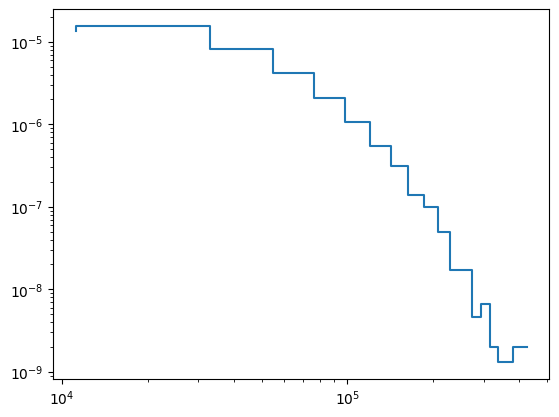

In [ ]:
plt.step(xbs,cs)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
cg,bg,igg= plt.hist(galaxy_zm_reshape, 20, density = True)
plt.xscale('log')
plt.yscale('log')
plt.close()

In [ ]:
xbg = bg[0:len(bg)-1] + np.diff(bg)/2

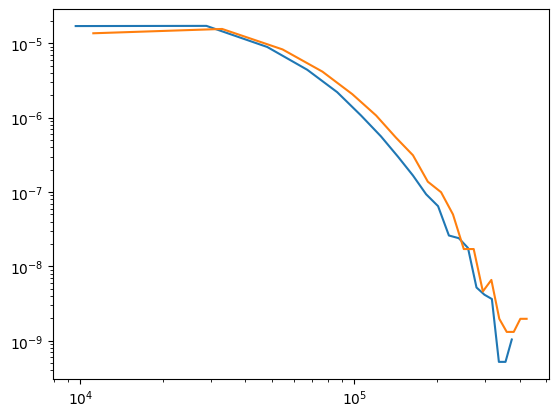

In [ ]:
plt.plot(xbg,cg)
plt.plot(xbs,cs)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
len(cons)

10

In [ ]:
model = SVC(kernel='rbf', probability=True, C=1, gamma='scale')

In [ ]:
gz2_training_model = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

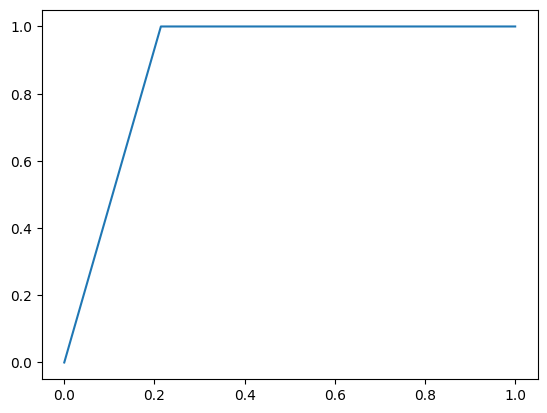

In [ ]:
plt.plot(fpr,tpr)
plt.show()

In [ ]:
con0 = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))
acc=accuracy_score(y_test, y_pred)
print(con0,acc,tss)

[[22  6]
 [ 0 39]] 0.9104477611940298 0.7857142857142857


In [ ]:
classification_metrics = classification_report(y_pred, y_test)
print(classification_metrics)

              precision    recall  f1-score   support

         0.0       0.34      0.78      0.48        27
         1.0       0.97      0.83      0.89       233

    accuracy                           0.82       260
   macro avg       0.66      0.80      0.69       260
weighted avg       0.90      0.82      0.85       260



In [ ]:
fp = []
tp = []
for j in range(10, 100, 15):
    j /= 100  # Convert j back to its original floating-point value
    batch_size = 32
    NUM_EPOCH = 10


    all_data = np.concatenate([zm1, zm2])
    all_labels = np.concatenate([stars_labels, galaxies_labels])

    X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=j)

    # X_test = X_test.reshape((X_test.shape[0], 903, 1))
    # y_train_encoded = to_categorical(y_train, num_classes=2)
    # y_test_encoded = to_categorical(y_test, num_classes=2)

    gz2_training_model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # y_pred_labels = np.argmax(y_pred, axis=1)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    fp.append(fpr)
    tp.append(tpr)

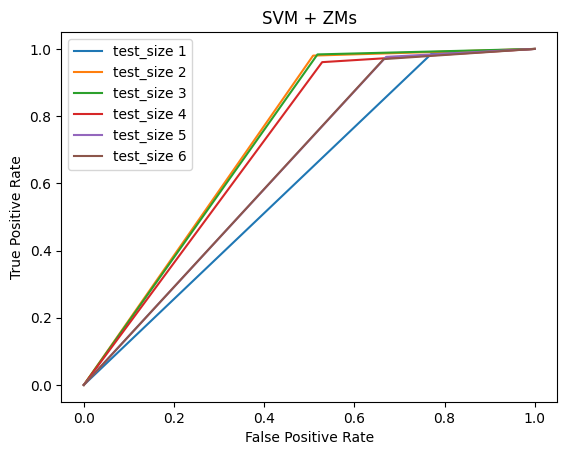

In [ ]:
for i in range(len(fp)):
    plt.plot(fp[i], tp[i], label=f'test_size {i+1}')

plt.title('SVM + ZMs')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
tsss = []
pred_list = []
X_list = []
y_list = []
models = []
accuracies = []

for i in range(10):
   L1 = np.random.randint(0, len(zm1), 260)
   L2 = np.random.randint(0, len(zm2), 350)
   all_data = np.concatenate([zm1[L1, :], zm2[L2, :]])
   all_labels = np.concatenate([stars_labels[L1], galaxies_labels[L2]])
   X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.98)
   X_list.append(X_train)
   y_list.append(y_train)
   gz2_training_model = model.fit(X_train, y_train)
   models.append(gz2_training_model)
   pred_labels = gz2_training_model.predict(X_test)
   pred_list.append(pred_labels)
   con0 = metrics.confusion_matrix(y_test, pred_labels)
   accuracy = accuracy_score(y_test, pred_labels)
   accuracies.append(accuracy)
   tp = con0[0,0]
   fn = con0[0,1]
   fp = con0[1,0]
   tn = con0[1,1]
   tss = (tp/(tp+fn))-(fp/(fp+tn))
   tsss.append(tss)

In [ ]:
mean_tss = np.mean(tsss)
std_tss = np.std(tsss)
print(mean_tss, std_tss)

0.10966186208480937 0.13630563279064326


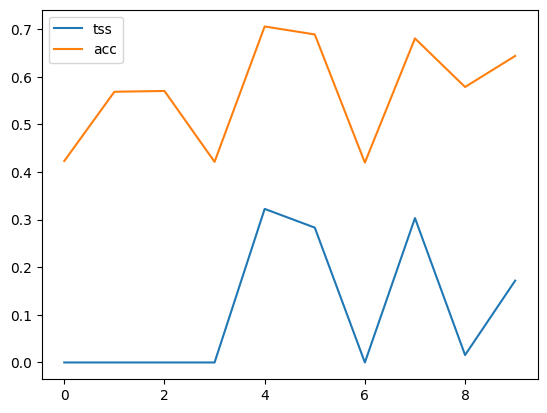

In [ ]:
plt.plot(tsss, label='tss')
plt.plot(accuracies, label='acc')
plt.legend()

In [ ]:
print(tsss[5],accuracies[5])

0.28326023391812866 0.6889632107023411


In [ ]:
from sklearn import metrics
y_pred = model.predict(X_test)
classification_metrics = metrics.classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

         0.0       0.92      0.18      0.31       256
         1.0       0.62      0.99      0.76       342

    accuracy                           0.64       598
   macro avg       0.77      0.59      0.53       598
weighted avg       0.75      0.64      0.57       598



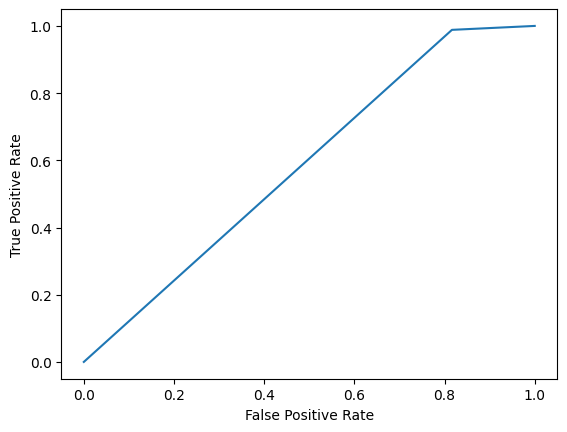

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.5859489217836257


In [ ]:
X_83 = []
y_83 = []

X_83.append(X_list[1])
y_83.append(y_list[1])
X_best = np.array(X_83)
y_best = np.array(y_83)

In [ ]:
best_model = models[1]

In [ ]:
pred_data = pd.read_csv('E:/Master_Thesis/Final_Codes/Zernike_data/sample_zm41_2_images.csv')
pred_data = np.array(pred_data)
# pred_data=pred_data.reshape(1,-1)

In [ ]:
np.shape(pred_data)

(2, 904)

In [ ]:
type(pred_data[0:1])

numpy.ndarray

In [ ]:
test_label = best_model.predict(pred_data)
print(test_label)

[0. 0.]


In [ ]:
Pkl_Filename = "best_svm_galaxy_star_tss83_acc91.sav"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
svm_galaxy_star_model = pickle.load(open('best_svm_galaxy_star_tss83_acc91.sav', 'rb'))

In [ ]:
pred_data = pd.read_csv('E:/Master_Thesis/Final_Codes/sample_zm41.csv')
pred_data = np.array(pred_data)

In [ ]:
test_label = svm_galaxy_star_model.predict(pred_data)
print(test_label)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
